In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)

import copy, pickle, bentoml
from tqdm import tqdm 
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

import pandas_profiling
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, \
                            recall_score, classification_report, plot_confusion_matrix
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# turn off all Anacondas warnings)
import warnings
warnings.filterwarnings('ignore')

### put .ipynb-file in the same folder, where are train_data.csv and test_data.csv

In [2]:
#path = "/Users/salikh-khabibullin/Desktop/ML Lab/stream_quality_data/"
path = "./"
data_train = pd.read_csv(path + "train_data.csv")
data_test = pd.read_csv(path + "test_data.csv")
print(data_train.shape, data_test.shape)

y_test = data_test["stream_quality"]

# I know, that it's not super optimal - I know about pd.concat() :)
da_train = copy.deepcopy(data_train)
da_test = copy.deepcopy(data_test)

# I know, that it's not super optimal - I know about pd.concat() :)
d_train = copy.deepcopy(data_train)
d_test = copy.deepcopy(data_test)

(406572, 12) (243596, 12)


In [3]:
t_train = copy.deepcopy(data_train)
t_test = copy.deepcopy(data_test)

In [4]:
data_train.head()

fps_mean   fps_std  fps_lags  rtt_mean    rtt_std  dropped_frames_mean  \
0      24.4  0.516398         0      91.1   6.723921                  0.0   
1      28.6  2.065591         0      99.7  15.923777                  0.0   
2      30.0  0.000000         0      98.1  11.798776                  0.0   
3      30.3  0.948683         0      99.4  13.014522                  0.0   
4      29.9  0.316228         0     123.2  62.476307                  0.0   

   dropped_frames_std  dropped_frames_max auto_bitrate_state auto_fec_state  \
0                 0.0                 0.0                off        partial   
1                 0.0                 0.0                off        partial   
2                 0.0                 0.0                off        partial   
3                 0.0                 0.0                off        partial   
4                 0.0                 0.0                off        partial   

   auto_fec_mean  stream_quality  
0           50.0               0  
1           50.0               0  
2           50.0               0  
3           50.0               0  
4           50.0               0

In [5]:
data_test.head()

fps_mean   fps_std  fps_lags  rtt_mean   rtt_std  dropped_frames_mean  \
0      29.9  0.316228         0      55.0  0.942809                  0.0   
1      30.0  0.000000         0      55.0  0.942809                  0.0   
2      30.0  0.000000         0      56.0  3.299832                  0.0   
3      29.9  0.316228         0      58.4  4.599517                  0.0   
4      30.0  0.000000         0      54.7  1.251666                  0.0   

   dropped_frames_std  dropped_frames_max auto_bitrate_state auto_fec_state  \
0                 0.0                 0.0                off        partial   
1                 0.0                 0.0                off        partial   
2                 0.0                 0.0                off        partial   
3                 0.0                 0.0                off        partial   
4                 0.0                 0.0                off        partial   

   auto_fec_mean  stream_quality  
0           50.0               0  
1           50.0               0  
2           50.0               0  
3           50.0               0  
4           50.0               0

In [6]:
# Create the data profile report
profileReport = pandas_profiling.profile_report.ProfileReport(data_train, title = "Report_Classification")
profileReport.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
profileReport

In [8]:
data_train["stream_quality"].value_counts()

0    378738
1     27834
Name: stream_quality, dtype: int64

### We have imbalanced dataset, so we must know it or create balanced dataset (by undersampling)

### First Model

### Let's built default Logistic Regression model

#w(j)=n/Kn(j)
#w(j) = weights of the classes
#n = number of observations
#K = Total number of classes
#n(j) = Number of observations in each class

n = data_train["stream_quality"].shape
K = 2
n_0, n_1 = data_train["stream_quality"].value_counts()[0], data_train["stream_quality"].value_counts()[1]
w_0, w_1 = n/(K*n_0), n/(K*n_1)
print("w_0 : ", w_0)
print("w_1 : ", w_1)

koef = data_train["stream_quality"].value_counts()[0]/data_train["stream_quality"].value_counts()[1]
koef = np.round(koef, 3)
print("koef = ", koef)

In [9]:
# solve the equation : (1 + koef)*w_koef = 100
#w_koef = 1/(1 + koef)
#w_koef = np.round(w_koef, 4)
#print("w_koef = ", w_koef)

y_train = data_train["stream_quality"]

['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'auto_bitrate_state', 'auto_fec_state', 'auto_fec_mean']


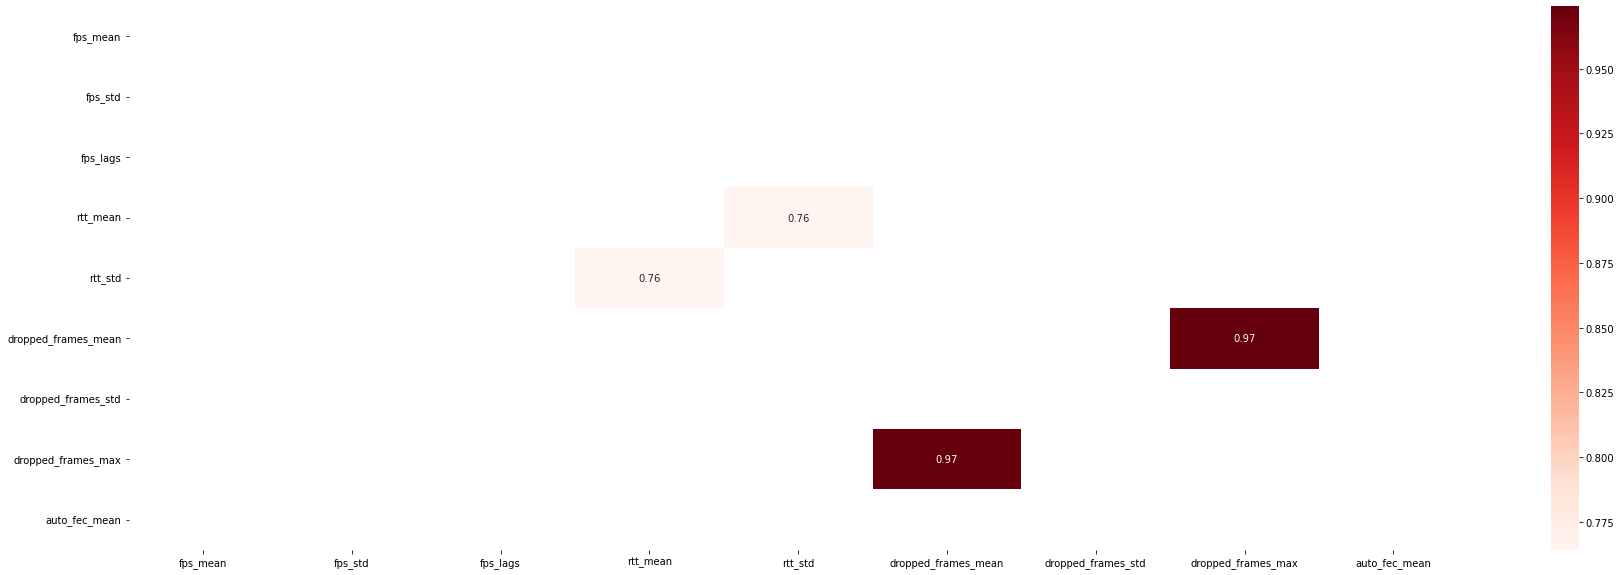

In [10]:
spi = list(data_train.columns)[:-1]
print(spi)

data_Corr = data_train[spi].corr(method = "pearson")
filteredDf = data_Corr[((data_Corr >= .5) | (data_Corr <= -.5)) & (data_Corr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

### I see high correlation between dropped_frames_mean and dropped_frames_max - so I want to drop dropped_frames_max

In [11]:
spisok = list(data_train.columns)[:-1]

# remove dropped_frames_max
spisok.remove("dropped_frames_max")
print(spisok)

data_train = data_train[spisok]
data_test = data_test[spisok]

['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'auto_bitrate_state', 'auto_fec_state', 'auto_fec_mean']


In [12]:
def ohe_scale(train, test, features):
    
    num = [cname for cname in features if train[cname].dtype in ['int64', 'float64']]
    cat = [cname for cname in features if train[cname].dtype == "object"]
    
    print(len(num), " num_cols : ", num)
    print(len(cat), " cat_cols : ", cat)
    print("number of cat_cols will increase ")
    
    # Encode categorical features
    encoder = OneHotEncoder(cols = cat, handle_unknown='ignore')

    train = encoder.fit_transform(train)
    test = encoder.transform(test)

    # Just scale numerical features
    scaler = StandardScaler()

    train[num] = scaler.fit_transform(train[num])
    test[num] = scaler.transform(test[num])
    return train, test

In [13]:
data_train, data_test = ohe_scale(data_train, data_test, spisok)

8  num_cols :  ['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'auto_fec_mean']
2  cat_cols :  ['auto_bitrate_state', 'auto_fec_state']
number of cat_cols will increase 


In [14]:
data_train.shape, data_test.shape

((406572, 13), (243596, 13))

In [15]:
data_train.head()

fps_mean   fps_std  fps_lags  rtt_mean   rtt_std  dropped_frames_mean  \
0 -0.868572 -0.477033 -0.166594  0.274782 -0.081867            -0.035099   
1 -0.507296 -0.059295 -0.166594  0.339023 -0.023031            -0.035099   
2 -0.386871 -0.616279 -0.166594  0.327071 -0.049412            -0.035099   
3 -0.361066 -0.360468 -0.166594  0.336782 -0.041637            -0.035099   
4 -0.395473 -0.531008 -0.166594  0.514564  0.274688            -0.035099   

   dropped_frames_std  auto_bitrate_state_1  auto_bitrate_state_2  \
0           -0.014933                     1                     0   
1           -0.014933                     1                     0   
2           -0.014933                     1                     0   
3           -0.014933                     1                     0   
4           -0.014933                     1                     0   

   auto_bitrate_state_3  auto_fec_state_1  auto_fec_state_2  auto_fec_mean  
0                     0                 1                 0      -0.040577  
1                     0                 1                 0      -0.040577  
2                     0                 1                 0      -0.040577  
3                     0                 1                 0      -0.040577  
4                     0                 1                 0      -0.040577

In [16]:
data_test.head()

fps_mean   fps_std  fps_lags  rtt_mean   rtt_std  dropped_frames_mean  \
0 -0.395473 -0.531008 -0.166594  0.005121 -0.118839            -0.035099   
1 -0.386871 -0.616279 -0.166594  0.005121 -0.118839            -0.035099   
2 -0.386871 -0.616279 -0.166594  0.012591 -0.103765            -0.035099   
3 -0.395473 -0.531008 -0.166594  0.030519 -0.095453            -0.035099   
4 -0.386871 -0.616279 -0.166594  0.002880 -0.116864            -0.035099   

   dropped_frames_std  auto_bitrate_state_1  auto_bitrate_state_2  \
0           -0.014933                     1                     0   
1           -0.014933                     1                     0   
2           -0.014933                     1                     0   
3           -0.014933                     1                     0   
4           -0.014933                     1                     0   

   auto_bitrate_state_3  auto_fec_state_1  auto_fec_state_2  auto_fec_mean  
0                     0                 1                 0      -0.040577  
1                     0                 1                 0      -0.040577  
2                     0                 1                 0      -0.040577  
3                     0                 1                 0      -0.040577  
4                     0                 1                 0      -0.040577

In [17]:
# Create some metrics to mearuse the quality

def calc_metrics(y_actual, y_pred):
    roc_auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)

    print("Roc_Auc : ", roc_auc)
    print("Acc : ", accuracy)
    print("Precisiom : ", precision)
    print("Recall : ", recall)
    return roc_auc, accuracy, precision, recall

In [18]:
def collect(model, train, y_train, test, y_test, some_dict):
    y_pred = model.predict(test)
    print(y_pred)

    roc_auc, accuracy, precision, recall = calc_metrics(y_test, y_pred)
    some_dict['Roc_Auc'] = roc_auc
    some_dict['Accuracy'] = accuracy
    some_dict['Precision'] = precision
    some_dict['Recall'] = recall
    some_frame = pd.DataFrame(data = some_dict)
    
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(model, test, y_test)
    #return True
    return some_frame

[0 0 0 ... 0 0 0]
Roc_Auc :  0.5694012895240173
Acc :  0.9410950918734298
Precisiom :  0.7145135566188198
Recall :  0.14272970561998216
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    227902
           1       0.71      0.14      0.24     15694

    accuracy                           0.94    243596
   macro avg       0.83      0.57      0.60    243596
weighted avg       0.93      0.94      0.92    243596

[0 0 0 ... 0 0 0]
Roc_Auc :  0.5633874166368856
Acc :  0.9404998440040067
Precisiom :  0.7071823204419889
Recall :  0.13049573085255511
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    227902
           1       0.71      0.13      0.22     15694

    accuracy                           0.94    243596
   macro avg       0.83      0.56      0.59    243596
weighted avg       0.93      0.94      0.92    243596

[0 0 0 ... 0 0 0]
Roc_Auc :  0.5633874166368856
Acc :  0.9404998440040067


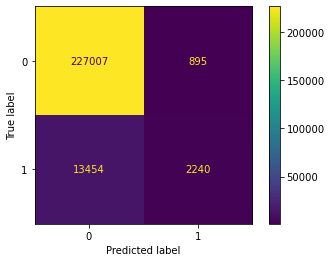

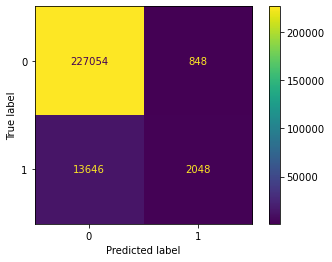

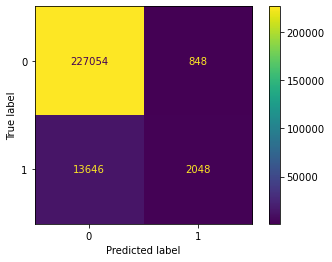

In [19]:
%%time

log_1 = LogisticRegression(penalty = 'none', 
                           random_state = 42).fit(data_train, y_train)
some_dict = {'Model': ["log_1"], 'Сlass ratio': ["imbalanced"], 
             'Removed outliers': ["No"], "Penalty": ["None"]}
frame_1 = collect(log_1, data_train, y_train, data_test, y_test, some_dict);

log_2 = LogisticRegression(solver = 'liblinear', 
                           penalty = 'l1', random_state = 42).fit(data_train, y_train) 
some_dict = {'Model': ["log_2"], 'Сlass ratio': ["imbalanced"], 
             'Removed outliers': ["No"], "Penalty": ["l1"]}
frame_2 = collect(log_2, data_train, y_train, data_test, y_test, some_dict);

log_3 = LogisticRegression(penalty = 'l2', 
                           random_state = 42).fit(data_train, y_train) 
some_dict = {'Model': ["log_2"], 'Сlass ratio': ["imbalanced"], 
             'Removed outliers': ["No"], "Penalty": ["l2"]}
frame_3 = collect(log_3, data_train, y_train, data_test, y_test, some_dict);

res_1 = pd.concat([frame_1, frame_2, frame_3])

%%time

log_1 = LogisticRegression(class_weight = {0: w_0, 1: w_1}, penalty = 'none', 
                           random_state = 42).fit(data_train, y_train)
some_dict = {'Model': ["log_1"], 'Сlass ratio': ["imbalanced"], 
             'Removed outliers': ["No"], "Penalty": ["None"]}
frame_1 = collect(log_1, data_train, y_train, data_test, y_test, some_dict);

log_2 = LogisticRegression(class_weight = {0: w_0, 1: w_1}, solver = 'liblinear', 
                           penalty = 'l1', random_state = 42).fit(data_train, y_train) 
some_dict = {'Model': ["log_2"], 'Сlass ratio': ["imbalanced"], 
             'Removed outliers': ["No"], "Penalty": ["l1"]}
frame_2 = collect(log_2, data_train, y_train, data_test, y_test, some_dict);

log_3 = LogisticRegression(class_weight = {0: w_0, 1: w_1}, penalty = 'l2', 
                           random_state = 42).fit(data_train, y_train) 
some_dict = {'Model': ["log_2"], 'Сlass ratio': ["imbalanced"], 
             'Removed outliers': ["No"], "Penalty": ["l2"]}
frame_3 = collect(log_3, data_train, y_train, data_test, y_test, some_dict);

res_1 = pd.concat([frame_1, frame_2, frame_3])

In [20]:
res_1

Model Сlass ratio Removed outliers Penalty   Roc_Auc  Accuracy  Precision  \
0  log_1  imbalanced               No    None  0.569401  0.941095   0.714514   
0  log_2  imbalanced               No      l1  0.563387  0.940500   0.707182   
0  log_2  imbalanced               No      l2  0.563387  0.940500   0.707182   

     Recall  
0  0.142730  
0  0.130496  
0  0.130496

### Second Model (equal shapes) - considering correctly their weight

### I will undersample the largest class - 0-class

In [21]:
small = da_train[da_train["stream_quality"] == 1]
print(small.shape, small.shape[0])

reduced = da_train[da_train["stream_quality"] == 0][:small.shape[0]]
print(reduced.shape)

data_equal = pd.concat([small, reduced])
print(data_equal.shape)

y_equal = data_equal["stream_quality"]

(27834, 12) 27834
(27834, 12)
(55668, 12)


In [22]:
small.head()

fps_mean   fps_std  fps_lags  rtt_mean    rtt_std  dropped_frames_mean  \
20      29.8  1.135292         0     135.1  61.529487                  0.0   
58      50.0  4.082483         0     224.7   0.674949                  0.0   
71      53.7  2.869379         0     213.2   0.632456                  0.0   
84      50.7  3.591657         0     229.3   6.056218                  0.0   
90      53.6  2.674987         0     211.7   0.674949                  0.0   

    dropped_frames_std  dropped_frames_max auto_bitrate_state auto_fec_state  \
20                 0.0                 0.0                off        partial   
58                 0.0                 0.0               full        partial   
71                 0.0                 0.0               full        partial   
84                 0.0                 0.0               full        partial   
90                 0.0                 0.0               full        partial   

    auto_fec_mean  stream_quality  
20           50.0               1  
58           50.0               1  
71           20.0               1  
84           22.0               1  
90           20.0               1

In [23]:
reduced.head()

fps_mean   fps_std  fps_lags  rtt_mean    rtt_std  dropped_frames_mean  \
0      24.4  0.516398         0      91.1   6.723921                  0.0   
1      28.6  2.065591         0      99.7  15.923777                  0.0   
2      30.0  0.000000         0      98.1  11.798776                  0.0   
3      30.3  0.948683         0      99.4  13.014522                  0.0   
4      29.9  0.316228         0     123.2  62.476307                  0.0   

   dropped_frames_std  dropped_frames_max auto_bitrate_state auto_fec_state  \
0                 0.0                 0.0                off        partial   
1                 0.0                 0.0                off        partial   
2                 0.0                 0.0                off        partial   
3                 0.0                 0.0                off        partial   
4                 0.0                 0.0                off        partial   

   auto_fec_mean  stream_quality  
0           50.0               0  
1           50.0               0  
2           50.0               0  
3           50.0               0  
4           50.0               0

In [24]:
data_equal.head()

fps_mean   fps_std  fps_lags  rtt_mean    rtt_std  dropped_frames_mean  \
20      29.8  1.135292         0     135.1  61.529487                  0.0   
58      50.0  4.082483         0     224.7   0.674949                  0.0   
71      53.7  2.869379         0     213.2   0.632456                  0.0   
84      50.7  3.591657         0     229.3   6.056218                  0.0   
90      53.6  2.674987         0     211.7   0.674949                  0.0   

    dropped_frames_std  dropped_frames_max auto_bitrate_state auto_fec_state  \
20                 0.0                 0.0                off        partial   
58                 0.0                 0.0               full        partial   
71                 0.0                 0.0               full        partial   
84                 0.0                 0.0               full        partial   
90                 0.0                 0.0               full        partial   

    auto_fec_mean  stream_quality  
20           50.0               1  
58           50.0               1  
71           20.0               1  
84           22.0               1  
90           20.0               1

In [25]:
data_test.head()

fps_mean   fps_std  fps_lags  rtt_mean   rtt_std  dropped_frames_mean  \
0 -0.395473 -0.531008 -0.166594  0.005121 -0.118839            -0.035099   
1 -0.386871 -0.616279 -0.166594  0.005121 -0.118839            -0.035099   
2 -0.386871 -0.616279 -0.166594  0.012591 -0.103765            -0.035099   
3 -0.395473 -0.531008 -0.166594  0.030519 -0.095453            -0.035099   
4 -0.386871 -0.616279 -0.166594  0.002880 -0.116864            -0.035099   

   dropped_frames_std  auto_bitrate_state_1  auto_bitrate_state_2  \
0           -0.014933                     1                     0   
1           -0.014933                     1                     0   
2           -0.014933                     1                     0   
3           -0.014933                     1                     0   
4           -0.014933                     1                     0   

   auto_bitrate_state_3  auto_fec_state_1  auto_fec_state_2  auto_fec_mean  
0                     0                 1                 0      -0.040577  
1                     0                 1                 0      -0.040577  
2                     0                 1                 0      -0.040577  
3                     0                 1                 0      -0.040577  
4                     0                 1                 0      -0.040577

In [26]:
spisok_equal = list(data_equal.columns)[:-1]

# remove dropped_frames_max
spisok_equal.remove("dropped_frames_max")
print(spisok_equal)

data_equal = data_equal[spisok_equal]
data_test = da_test[spisok_equal]

['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'auto_bitrate_state', 'auto_fec_state', 'auto_fec_mean']


In [27]:
data_equal, data_test = ohe_scale(data_equal, data_test, spisok_equal)

8  num_cols :  ['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'auto_fec_mean']
2  cat_cols :  ['auto_bitrate_state', 'auto_fec_state']
number of cat_cols will increase 


[0 0 0 ... 0 0 0]
Roc_Auc :  0.7098884616684182
Acc :  0.8580395408791606
Precisiom :  0.23644330328486507
Recall :  0.5398241366127182
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    227902
           1       0.24      0.54      0.33     15694

    accuracy                           0.86    243596
   macro avg       0.60      0.71      0.62    243596
weighted avg       0.92      0.86      0.88    243596

[0 0 0 ... 0 0 0]
Roc_Auc :  0.7098302752536177
Acc :  0.8579861738287985
Precisiom :  0.2363428380112717
Recall :  0.5397604179941379
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    227902
           1       0.24      0.54      0.33     15694

    accuracy                           0.86    243596
   macro avg       0.60      0.71      0.62    243596
weighted avg       0.92      0.86      0.88    243596

[0 0 0 ... 0 0 0]
Roc_Auc :  0.709791928948214
Acc :  0.8578589139394736
Pr

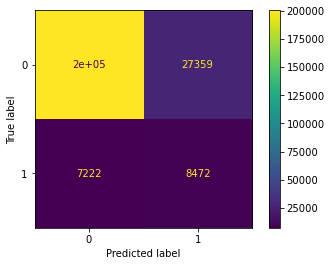

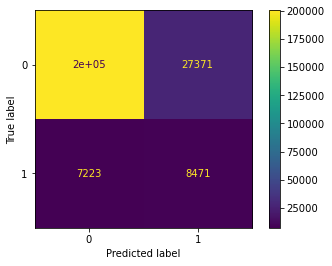

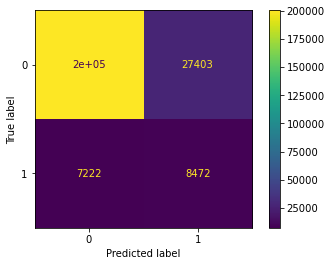

In [28]:
%%time

log_equal_1 = LogisticRegression(class_weight = "balanced", penalty = 'none', 
                                 random_state = 42).fit(data_equal, y_equal)
some_dict = {'Model': ["log_equal_1"], 'Сlass ratio': ["balanced"], 
             'Removed outliers': ["No"], "Penalty": ["None"]}
frame_4 = collect(log_equal_1, data_equal, y_equal, data_test, y_test, some_dict);

log_equal_2 = LogisticRegression(class_weight = "balanced", solver = 'liblinear', 
                               penalty = 'l1', random_state = 42).fit(data_equal, y_equal)
some_dict = {'Model': ["log_equal_2"], 'Сlass ratio': ["balanced"], 
             'Removed outliers': ["No"], "Penalty": ["l1"]}
frame_5 = collect(log_equal_2, data_equal, y_equal, data_test, y_test, some_dict);

log_equal_3 = LogisticRegression(class_weight = "balanced", penalty = 'l2', 
                                 random_state = 42).fit(data_equal, y_equal)
some_dict = {'Model': ["log_equal_3"], 'Сlass ratio': ["balanced"], 
             'Removed outliers': ["No"], "Penalty": ["l2"]}
frame_6 = collect(log_equal_3, data_equal, y_equal, data_test, y_test, some_dict);

res_2 = pd.concat([frame_4, frame_5, frame_6])

In [29]:
res_2

Model Сlass ratio Removed outliers Penalty   Roc_Auc  Accuracy  \
0  log_equal_1    balanced               No    None  0.709888  0.858040   
0  log_equal_2    balanced               No      l1  0.709830  0.857986   
0  log_equal_3    balanced               No      l2  0.709792  0.857859   

   Precision    Recall  
0   0.236443  0.539824  
0   0.236343  0.539760  
0   0.236153  0.539824

# Third model (Let's remove all outlies)

In [30]:
d_train.head()

fps_mean   fps_std  fps_lags  rtt_mean    rtt_std  dropped_frames_mean  \
0      24.4  0.516398         0      91.1   6.723921                  0.0   
1      28.6  2.065591         0      99.7  15.923777                  0.0   
2      30.0  0.000000         0      98.1  11.798776                  0.0   
3      30.3  0.948683         0      99.4  13.014522                  0.0   
4      29.9  0.316228         0     123.2  62.476307                  0.0   

   dropped_frames_std  dropped_frames_max auto_bitrate_state auto_fec_state  \
0                 0.0                 0.0                off        partial   
1                 0.0                 0.0                off        partial   
2                 0.0                 0.0                off        partial   
3                 0.0                 0.0                off        partial   
4                 0.0                 0.0                off        partial   

   auto_fec_mean  stream_quality  
0           50.0               0  
1           50.0               0  
2           50.0               0  
3           50.0               0  
4           50.0               0

In [31]:
d_train.shape

(406572, 12)

In [32]:
features = list(d_train.columns)
print(features)

feat_1 = ['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std']
feat_2 = ['dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'auto_fec_mean']

['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'auto_bitrate_state', 'auto_fec_state', 'auto_fec_mean', 'stream_quality']


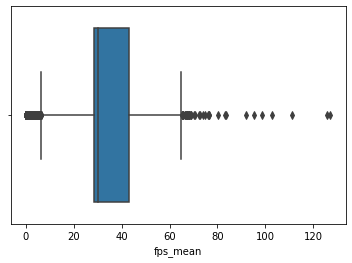

In [33]:
sns.boxplot(x = d_train["fps_mean"]);

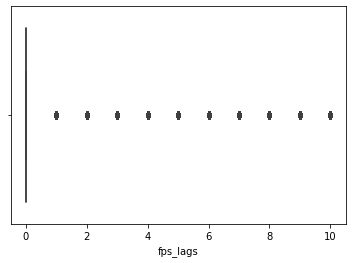

In [34]:
sns.boxplot(x = d_train["fps_lags"]);

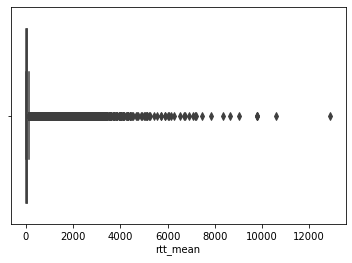

In [35]:
sns.boxplot(x = d_train["rtt_mean"]);

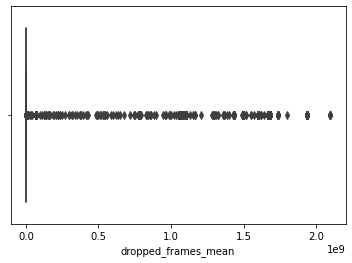

In [36]:
sns.boxplot(x = d_train["dropped_frames_mean"]);

In [37]:
def remove_outlies(data, feature):
    Q1 = data[feature].quantile(0.25) # 0.05
    Q3 = data[feature].quantile(0.75) # 0.95
    IQR = Q3 - Q1
    
    filter = (data[feature] >= Q1 - 1.5 * IQR) & (data[feature] <= Q3 + 1.5 *IQR)
    return data.loc[filter]

In [38]:
#for f in feat_1:
#    data_train = remove_outlies(data_train, str(f))

#for f in feat_2:
#    data_train = remove_outlies(data_train, str(f))

#for f in features:
#    data_train = remove_outlies(data_train[data_train["stream_quality"] == 0], str(f))

In [39]:
data_with_0 = d_train[d_train["stream_quality"] == 0]
data_with_1 = d_train[d_train["stream_quality"] == 1]

df_1 = remove_outlies(data_with_0, "fps_mean")
df_2 = remove_outlies(data_with_0, "fps_std")
df_3 = remove_outlies(data_with_0, "fps_lags")
df_4 = remove_outlies(data_with_0, "rtt_mean")
df_5 = remove_outlies(data_with_0, "rtt_std")
df_6 = remove_outlies(data_with_0, "dropped_frames_mean")
df_7 = remove_outlies(data_with_0, "dropped_frames_std")
df_8 = remove_outlies(data_with_0, "auto_fec_mean")
df_9 = remove_outlies(data_with_0, "dropped_frames_max")

In [40]:
data_all_0 = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9])
print(data_all_0.shape)

(3128191, 12)


In [41]:
data_last = pd.concat([data_all_0, data_with_1])
data_last = data_last.drop_duplicates()

print(data_last.shape)

y_last = data_last["stream_quality"]

(373140, 12)


In [42]:
spisok_last = list(data_last.columns)[:-1]

# remove dropped_frames_max
spisok_last.remove("dropped_frames_max")
print(spisok_last)

data_last = data_last[spisok_last]
data_test = da_test[spisok_last]

['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'auto_bitrate_state', 'auto_fec_state', 'auto_fec_mean']


In [43]:
data_last, data_test = ohe_scale(data_last, data_test, spisok_last)

8  num_cols :  ['fps_mean', 'fps_std', 'fps_lags', 'rtt_mean', 'rtt_std', 'dropped_frames_mean', 'dropped_frames_std', 'auto_fec_mean']
2  cat_cols :  ['auto_bitrate_state', 'auto_fec_state']
number of cat_cols will increase 


[0 0 0 ... 0 0 0]
Roc_Auc :  0.7104422747725434
Acc :  0.8746736399612474
Precisiom :  0.2623890828715123
Recall :  0.5219192047916401
              precision    recall  f1-score   support

           0       0.96      0.90      0.93    227902
           1       0.26      0.52      0.35     15694

    accuracy                           0.87    243596
   macro avg       0.61      0.71      0.64    243596
weighted avg       0.92      0.87      0.89    243596

[0 0 0 ... 0 0 0]
Roc_Auc :  0.7104488565489209
Acc :  0.8746859554344077
Precisiom :  0.2624143012750689
Recall :  0.5219192047916401
              precision    recall  f1-score   support

           0       0.96      0.90      0.93    227902
           1       0.26      0.52      0.35     15694

    accuracy                           0.87    243596
   macro avg       0.61      0.71      0.64    243596
weighted avg       0.92      0.87      0.89    243596

[0 0 0 ... 0 0 0]
Roc_Auc :  0.7104466626234618
Acc :  0.8746818502766877
Pr

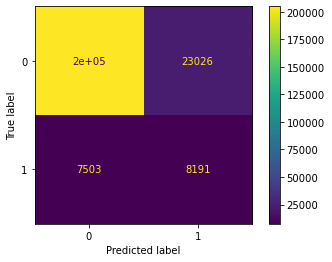

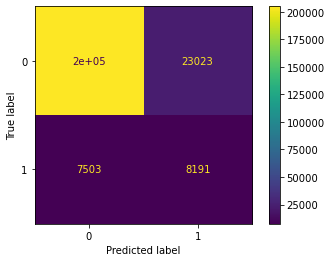

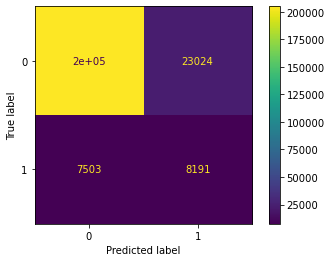

In [44]:
%%time

log_last_1 = LogisticRegression(class_weight = "balanced", penalty = 'none', 
                                random_state = 42).fit(data_last, y_last)
some_dict = {'Model': ["log_last_1"], 'Сlass ratio': ["balanced"], 
             'Removed outliers': ["Yes"], "Penalty": ["None"]}
frame_7 = collect(log_last_1, data_last, y_last, data_test, y_test, some_dict);

log_last_2 = LogisticRegression(class_weight = "balanced", solver = 'liblinear', 
                                penalty = 'l1', random_state = 42).fit(data_last, y_last)
some_dict = {'Model': ["log_last_2"], 'Сlass ratio': ["balanced"], 
             'Removed outliers': ["Yes"], "Penalty": ["l1"]}
frame_8 = collect(log_last_2, data_last, y_last, data_test, y_test, some_dict);

log_last_3 = LogisticRegression(class_weight = "balanced", penalty = 'l2', 
                                random_state = 42).fit(data_last, y_last)
some_dict = {'Model': ["log_last_3"], 'Сlass ratio': ["balanced"], 
             'Removed outliers': ["Yes"], "Penalty": ["l2"]}
frame_9 = collect(log_last_3, data_last, y_last, data_test, y_test, some_dict);

res_3 = pd.concat([frame_7, frame_8, frame_9])

In [45]:
res_3

Model Сlass ratio Removed outliers Penalty   Roc_Auc  Accuracy  \
0  log_last_1    balanced              Yes    None  0.710442  0.874674   
0  log_last_2    balanced              Yes      l1  0.710449  0.874686   
0  log_last_3    balanced              Yes      l2  0.710447  0.874682   

   Precision    Recall  
0   0.262389  0.521919  
0   0.262414  0.521919  
0   0.262406  0.521919

In [46]:
result = pd.concat([res_1, res_2, res_3])

In [47]:
result

Model Сlass ratio Removed outliers Penalty   Roc_Auc  Accuracy  \
0        log_1  imbalanced               No    None  0.569401  0.941095   
0        log_2  imbalanced               No      l1  0.563387  0.940500   
0        log_2  imbalanced               No      l2  0.563387  0.940500   
0  log_equal_1    balanced               No    None  0.709888  0.858040   
0  log_equal_2    balanced               No      l1  0.709830  0.857986   
0  log_equal_3    balanced               No      l2  0.709792  0.857859   
0   log_last_1    balanced              Yes    None  0.710442  0.874674   
0   log_last_2    balanced              Yes      l1  0.710449  0.874686   
0   log_last_3    balanced              Yes      l2  0.710447  0.874682   

   Precision    Recall  
0   0.714514  0.142730  
0   0.707182  0.130496  
0   0.707182  0.130496  
0   0.236443  0.539824  
0   0.236343  0.539760  
0   0.236153  0.539824  
0   0.262389  0.521919  
0   0.262414  0.521919  
0   0.262406  0.521919

### Best model is the last model (log_last_3) with Сlass ratio (balanced), Removed outliers(Yes) and good roc_auc
### log_last_2 is very close to log_last_3

### I knew that I could built only 3 models instead of 9)))